In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [23]:
# Load hourly merged data
df = pd.read_csv("data/merged.csv")        # adjust path if needed
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

# 6 days = 144 hours
HORIZON_HOURS = 144
df["Q_future_144"] = df["Q"].shift(-HORIZON_HOURS)

# Drop last 144 hours (no future Q)
df = df.dropna(subset=["Q_future_144"]).reset_index(drop=True)

df.head()


,datetime,pr,Q,Q_future_144
0,1995-09-01 00:00:00,0.0,15.339605,10.494048
1,1995-09-01 01:00:00,0.0,15.305955,10.460398
2,1995-09-01 02:00:00,0.0,15.272305,10.426749
3,1995-09-01 03:00:00,0.0,15.238656,10.393099
4,1995-09-01 04:00:00,0.0,15.205006,10.359449


In [24]:
FEATURE_COLS = ["pr", "Q"]

n = len(df)
train_end = int(n * 0.7)
val_end   = int(n * 0.85)

print("Rows:", n, " Train end:", train_end, " Val end:", val_end)


Rows: 213168  Train end: 149217  Val end: 181192


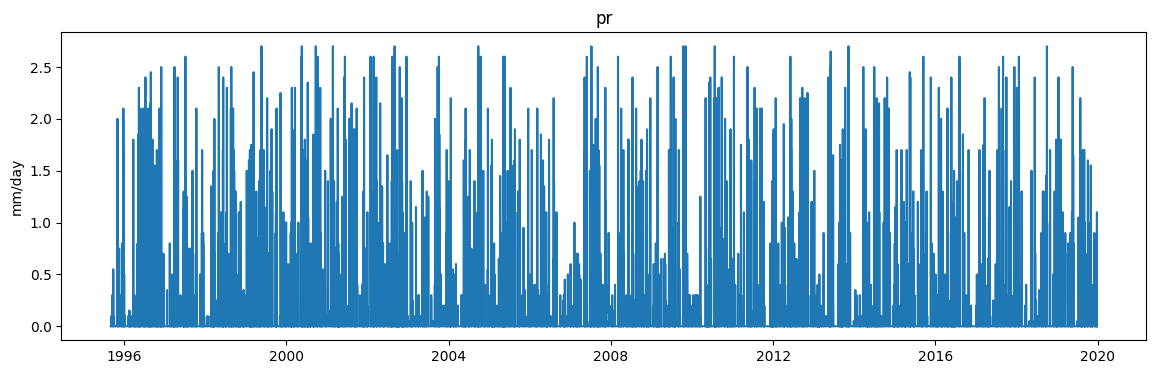

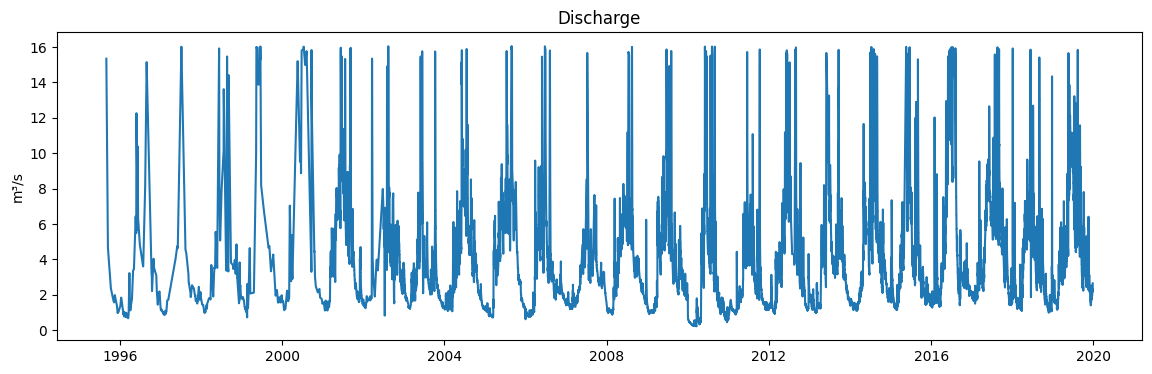

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(df["datetime"], df["pr"])
plt.title("pr")
plt.ylabel("mm/day")
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df["datetime"], df["Q"])
plt.title("Discharge")
plt.ylabel("m³/s")
plt.show()


In [28]:
feat_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit on training period only (to avoid data leakage)
feat_scaler.fit(df[FEATURE_COLS].iloc[:train_end])
target_scaler.fit(df[["Q_future_144"]].iloc[:train_end])

# Transform all rows (using params learned from train)
df_scaled_feats = feat_scaler.transform(df[FEATURE_COLS])
df_scaled_target = target_scaler.transform(df[["Q_future_144"]])

df_feat_scaled = pd.DataFrame(df_scaled_feats, columns=FEATURE_COLS)
df_target_scaled = pd.Series(df_scaled_target.flatten(), name="Q_future_144_scaled")

df_scaled = pd.concat([df[["datetime"]], df_feat_scaled, df_target_scaled], axis=1)
df_scaled.head()


,datetime,pr,Q,Q_future_144_scaled
0,1995-09-01 00:00:00,-0.182843,3.369105,1.927973
1,1995-09-01 01:00:00,-0.182843,3.359034,1.917868
2,1995-09-01 02:00:00,-0.182843,3.348964,1.907763
3,1995-09-01 03:00:00,-0.182843,3.338893,1.897658
4,1995-09-01 04:00:00,-0.182843,3.328822,1.887553


In [37]:
import tensorflow as tf

FEATURE_COLS = ["pr", "Q"]
WINDOW_HOURS = 24 * 7     # 7 days history
BATCH_SIZE = 64           # larger batch = faster on CPU/GPU

data_array   = df_scaled[FEATURE_COLS].values.astype("float32")
target_array = df_scaled["Q_future_144_scaled"].values.astype("float32")

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=data_array[:train_end],
    targets=target_array[:train_end],
    sequence_length=WINDOW_HOURS,
    sequence_stride=6,    # <--- was 1, now every 6 hours
    shuffle=False,
    batch_size=BATCH_SIZE,
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=data_array[train_end:val_end],
    targets=target_array[train_end:val_end],
    sequence_length=WINDOW_HOURS,
    sequence_stride=6,    # same stride
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=data_array[val_end:],
    targets=target_array[val_end:],
    sequence_length=WINDOW_HOURS,
    sequence_stride=6,
    shuffle=False,
    batch_size=BATCH_SIZE,
)


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

n_timesteps = WINDOW_HOURS
n_features  = len(FEATURE_COLS)

model = Sequential([
    LSTM(32, input_shape=(n_timesteps, n_features)),  # single small LSTM
    Dropout(0.3),
    Dense(16, activation="relu"),
    Dense(1),
])

model.compile(optimizer="adam", loss="mse")
model.summary()


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,025 (19.63 KB)

 Trainable params: 5,025 (19.63 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
es = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,          # instead of 50+
    callbacks=[es],
    verbose=1,
)


Epoch 1/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.2629 - val_loss: 0.0562
Epoch 2/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0934 - val_loss: 0.0522
Epoch 3/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0695 - val_loss: 0.0510
Epoch 4/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0449 - val_loss: 0.0421
Epoch 5/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0702 - val_loss: 0.0333
Epoch 6/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0462 - val_loss: 0.0392
Epoch 7/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0387 - val_loss: 0.0355
Epoch 8/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0371 - val_loss: 0.0448


In [40]:
# collect true and predicted values from test_dataset
y_test_list = []
y_pred_list = []

for batch_x, batch_y in test_dataset:
    preds = model.predict(batch_x, verbose=0)
    y_test_list.append(batch_y.numpy())
    y_pred_list.append(preds)

y_test_scaled = np.concatenate(y_test_list, axis=0)
y_pred_scaled = np.concatenate(y_pred_list, axis=0)

# back to original units
y_test_inv = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)
r2   = r2_score(y_test_inv, y_pred_inv)

print("Test RMSE:", rmse)
print("Test R²:", r2)


Test RMSE: 0.7341635
Test R²: 0.9523380398750305


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


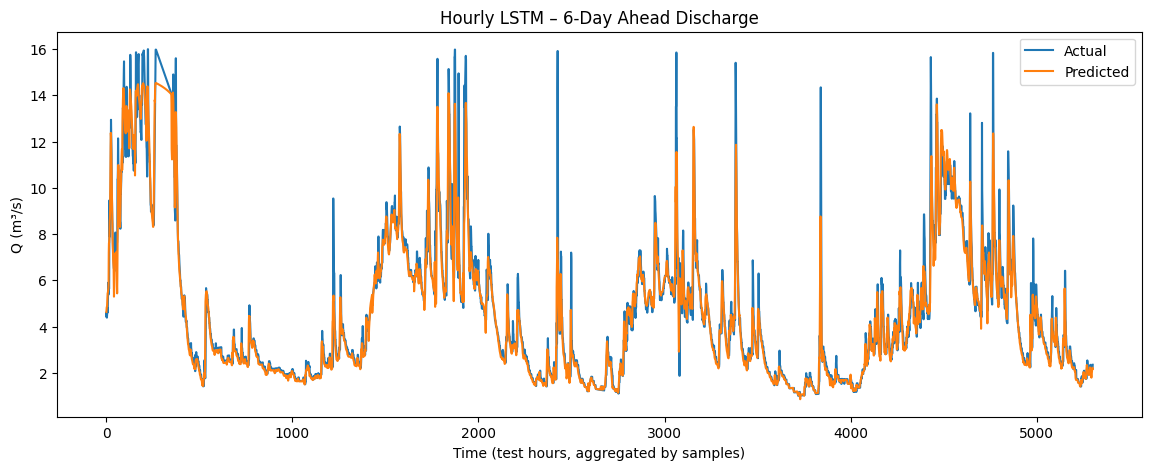

In [42]:
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.title("Hourly LSTM – 6-Day Ahead Discharge")
plt.xlabel("Time (test hours, aggregated by samples)")
plt.ylabel("Q (m³/s)")
plt.legend()
plt.show()
